In [1]:
#!pip install --upgrade ~/Development/repos/tradeframework
#!pip install --upgrade ~/Development/repos/tradeframework-insights
#!pip install --upgrade ~/Development/repos/quantutils
#!pip install --upgrade ~/Development/repos/marketinsights-price-aggregator

# Pkg imports
from tradeframework.api.insights import InsightManager
# TODO - dynamic import of SandboxEnv
from tradeframework.environments import SandboxEnvironment  
from marketinsights.api.aggregator import MarketDataAggregator
from quantutils.api.datasource import MIDataStoreRemote

# Dev imports
import pandas as pd
import numpy as np
import tradeframework.operations.trader as trader
import tradeframework.operations.utils as utils

#import matplotlib
#%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

import warnings
warnings.filterwarnings(action='ignore')


In [5]:
mds = MIDataStoreRemote(location="http://pricestore.192.168.1.203.nip.io")
mds.aggregate("DOW", ["WallSt-hourly"], '2013-01-01', '2018-08-03', debug=True)
#http://pricestore.192.168.1.203.nip.io/prices/aggregate/DOW?start=2013-01-01&end=2018-08-03&sources=WallSt-hourly


http://pricestore.192.168.1.203.nip.io/prices/aggregate/DOW?start=2013-01-01&end=2018-08-03&sources=WallSt-hourly
http://pricestore.192.168.1.203.nip.io/prices/aggregate/DOW?start=2013-01-01&end=2018-08-03&sources=WallSt-hourly


,,Open,High,Low,Close
Date_Time,ID,,,,
2016-04-19 13:00:00+00:00,WallSt-hourly,18051.0,18087.5,18023.5,18084.1
2016-04-19 14:00:00+00:00,WallSt-hourly,18084.0,18101.0,18044.9,18077.0
2016-04-19 15:00:00+00:00,WallSt-hourly,18076.0,18087.1,18015.0,18023.0
2016-04-19 16:00:00+00:00,WallSt-hourly,18023.1,18028.1,17983.5,18013.0
2016-04-19 17:00:00+00:00,WallSt-hourly,18012.7,18042.1,18009.0,18039.1
...,...,...,...,...,...
2018-08-02 19:00:00+00:00,WallSt-hourly,25324.0,25350.5,25304.5,25329.5
2018-08-02 20:00:00+00:00,WallSt-hourly,25329.0,25361.5,25327.0,25353.5
2018-08-02 22:00:00+00:00,WallSt-hourly,25361.5,25361.5,25342.0,25345.5


In [2]:
from pytickersymbols import PyTickerSymbols

stock_data = PyTickerSymbols()

stocks = stock_data.get_stocks_by_index('S&P 500')

tkrs = [x["symbol"] for x in list(stocks)]
tkrs = tkrs[:10]
tkrs.append("^GSPC")

markets = []
[markets.append({"ID": ticker, "sources":[ { "ID": ticker, "sample_unit":"D" }]}) for ticker in tkrs] 

data_config = [
    {
        "ID": "yahoo",
        "class": "YahooConnector",
        "opts": {
            "interval":"1d"
        },
        "timezone":"UTC",
        "markets": markets

    }
]

data_config = [
    {
        "ID": "MDS",
        "class": "MDSConnector",
        "opts": {
            "remote": True,
            "location": "http://pricestore.192.168.1.203.nip.io"
        },
        "timezone": "UTC",
        "markets": [
            {
                "ID": "DOW",
                "sources": [
                    {
                        "ID": "WallSt-hourly",
                        "sample_unit": "H"
                    },
                    {
                        "ID": "D&J-IND",
                        "sample_unit": "5min"
                    }
                ]
            }
        ]

    }
]


data_config

[{'ID': 'MDS',
  'class': 'MDSConnector',
  'opts': {'remote': True,
   'location': 'http://pricestore.192.168.1.203.nip.io'},
  'timezone': 'UTC',
  'markets': [{'ID': 'DOW',
    'sources': [{'ID': 'WallSt-hourly', 'sample_unit': 'H'},
     {'ID': 'D&J-IND', 'sample_unit': '5min'}]}]}]

In [3]:
## Get Market Data
aggregator = MarketDataAggregator(data_config)
   
#start = "2013-01-01"
#end = "2018-08-03"

start = "2015-01-01"

marketData = aggregator.getData(aggregate=False, debug=True)
print("Data Loaded")
#marketData = marketData.xs("mID")
marketData = marketData.tz_convert("US/Eastern", level="Date_Time")
marketData = marketData.unstack(level=0).dropna(axis=1).stack()
tickers = marketData.index.get_level_values("mID").unique().values
marketData

['DOW', ['WallSt-hourly'], '1979-01-01', '2050-01-01']


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



AttributeError: 'NoneType' object has no attribute 'empty'

In [14]:
marketData = pd.read_pickle("file.pkl")
tickers = marketData.index.get_level_values("mID").unique().values


In [4]:
env = SandboxEnvironment("TradeFair", "US/Eastern")

assetData = marketData[marketData.index.get_level_values("mID").isin(tickers)]
env.createAssets(assetData)
#tickers = tickers[:-1] # Remove baseline

#opt = env.createOptimizer("KellyOptimizer", "KellyOpt", opts={"window":40*24, "weight":.01})
p = env.createDerivative("MyPortfolio", weightGenerator=env.createOptimizer("EqualWeightsOptimizer", opts={"weight":1.0}))
#p = env.createDerivative("MyPortfolio", weightGenerator=env.createOptimizer("KellyOptimizer", opts={"window":200, "weight":1.0}))
env.setPortfolio(p)

# Create baseline as an unweighted asset
#baseline = env.createDerivative("Baseline", weightGenerator=env.createModel("BuyAndHold"))
#baseline.addStoredAsset(["^GSPC"])
#p.addAsset(baseline, weighted=False)

# Non-Weighted Portfolio (Indicator)
indicatorP = env.createDerivative("Indicators")
p.addAsset(indicatorP, weighted=False)
#indicatorP.addAsset(env.createModel( "TrendFollowingIndicator", "TrendFollowing", opts={"start": "15:00", "end": "16:00", "barOnly": True} ))
#indicatorP.addAsset(env.createModel( "MA20", "MovingAverage", opts={"ma1_win":20} ))
#indicatorP.addAsset(env.createModel( "MAXOver", "MovingAverageXOver", opts={"ma1_fast":50, "ma2_slow":200} ))
#indicatorP.addAsset(env.createModel( "MADailyX", "MovingAverageResampleXOver", opts={"ma1_fast":1, "ma2_slow":20, "src_sample":"H", "tgt_sample":"W"} ))
#indicatorP.addAsset(env.createModel( "StochOSC1", "StochasticOscXOver", opts={"window":14, "src_sample":"H", "tgt_sample":"W-MON" } ))
#indicatorP.addAsset(env.createModel( "StochOSC2", "StochasticOscXOver", opts={"window":14, "src_sample":"H", "tgt_sample":"D"} ))
#indicatorP.addAsset(env.createModel( "StochOSC3", "StochasticOscXOver", opts={"window":14, "src_sample":"H", "tgt_sample":"H"} ))
#indicatorP.addAsset(env.createModel( "BuyAndHoldIndicator", "BuyAndHold" ))
[indicatorP.addAsset(env.createDerivative("StochOSC-"+assetName, weightGenerator=env.createModel("StochasticOscXOver", opts={"window":5, "threshold":20})).addStoredAsset([assetName])) for assetName in tickers]
[indicatorP.addAsset(env.createDerivative("BuyAndHold-"+assetName, weightGenerator=env.createModel("BuyAndHold")).addStoredAsset([assetName])) for assetName in tickers]

#p.addAsset(MovingAverage("MA20", env, 14))

# Combination Model (using Indicators)
#p.addAsset(env.createModel("CombiTrendAndBuy", "CombinationModel", opts={"modelList": [ "StochOSC1", "StochOSC2", "BuyAndHoldIndicator"]}))
[p.addAsset(env.createDerivative("CombiTrendAndBuy-"+assetName, weightGenerator=env.createModel("CombinationModel", opts={"modelList": [ "StochOSC-"+assetName, "BuyAndHold-"+assetName]})).addStoredAsset([assetName])) for assetName in tickers]


# Custom Models
#p.addAsset(env.createModel( "D1-PreOpenMomentum", "PreOpenMomentum" ))
#p.addAsset(env.createModel( "MA20", "MovingAverage", opts={"ma1_win":20} ))
#p.addAsset(env.createModel( "MAX", "MovingAverageXOver", opts={"ma1_fast":50, "ma2_slow":200} ))
#p.addAsset(env.createModel( "MADaily", "MovingAverageResample", opts={"ma1_win":200, "src_sample":"H", "tgt_sample":"B"} ))
#p.addAsset(env.createModel( "MADailyX", "MovingAverageResampleXOver", opts={"ma1_fast":1, "ma2_slow":12, "src_sample":"H", "tgt_sample":"MS"} ))
#p.addAsset(env.createModel( "MADailyX2", "MovingAverageResampleXOver", opts={"ma1_fast":4, "ma2_slow":52, "src_sample":"H", "tgt_sample":"W-MON"} ))
#p.addAsset(env.createModel( "MADailyX2", "MovingAverageResampleXOver", opts={"ma1_fast":50, "ma2_slow":200, "src_sample":"H", "tgt_sample":"D"} ))
#p.addAsset(env.createModel( "StochOSC", "StochasticOscXOver", opts={"window":9, "src_sample":"D", "tgt_sample":"W-MON"} ))

# All hours
#p.addAsset(env.createModel( "D2-BuyAndHold", "BuyAndHold"))
#p.addAsset(env.createDerivative("D2-BuyAndHold", weightGenerator=env.createModel("BuyAndHold")).addStoredAsset(["DOW", ]))
#p.addAsset(env.createDerivative("D2-BuyAndHold2", weightGenerator=env.createModel("BuyAndHold")).addStoredAsset(["IBM"]))

# MultiAsset
#[p.addAsset(env.createDerivative("D2-BuyAndHold-"+assetName, weightGenerator=env.createModel("StochasticOscXOver", opts={"window":5, "threshold":20})).addStoredAsset([assetName])) for assetName in tickers]

# Market Opening hours only
#p.addAsset(env.createModel( "D3-BuyAndHold7", "BuyAndHold", opts={"start":"09:00", "end":"16:00"}))

# Individual hours
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold6", args=("10:00", "11:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold5", args=("11:00", "12:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold4", args=("12:00", "13:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold3", args=("13:00", "14:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold2", args=("14:00", "15:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold1", args=("15:00", "16:00")))
#d = env.createDerivative("TestModel", weightGenerator=env.createModel("TrendFollowing", opts={"start": "15:00", "end": "16:00", "barOnly": True}))

# ML models
threshold = 0
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBootstrap_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '4892e256e17f4fad775119304ee7e6d1', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBootstrap_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '4892e256e17f4fad775119304ee7e6d1', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBoosting_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '83c0ff9eeb24c87dbb0af766ab59ef75', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBoosting_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '83c0ff9eeb24c87dbb0af766ab59ef75', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Boosting_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', 'f2efe64bbc39ad0880337120f32ca12b', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Boosting_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', 'f2efe64bbc39ad0880337120f32ca12b', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Bootstrap_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '078df5a1afbaa2290ee93b4a562e3898', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Bootstrap_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '078df5a1afbaa2290ee93b4a562e3898', threshold)))

#Sandbox
#p.addAsset(env.createModel( "D3-BuyAndHold7", "BuyAndHold"))
#p.addAsset(env.createModel( "D3-BuyAndHold7", "SellAndHold", opts={"start":"09:00", "end":"16:00", "barOnly":"True"}))

# Feed data into the portfolio
env.refresh()




[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [1. 1.]
 [0. 0.]
 [0. 0.]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 ...
 [-1. -1.]
 [ 0.  0.]
 [ 0.  0.]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 

In [25]:
buySignals = [signal["markets"][0]["name"] for signal in results["UnderlyingSignals"]]

In [35]:
(results["CorrelationMatrix"]**2).sum().sort_values()[:20]

NEM      9.145255
KR      12.322242
CPB     18.710221
CLX     19.625267
ENPH    21.864480
BIIB    22.081121
DPZ     23.324882
SJM     24.156144
CAG     25.314614
ATVI    26.171299
INCY    28.533127
REGN    28.845814
K       28.983464
HRL     29.466601
GIS     29.993143
EA      30.004177
CTRA    30.566082
DXCM    30.568446
NFLX    30.761962
TTWO    31.239337
dtype: float64

In [36]:
results["CorrelationMatrix"]["NEM"]

MyPortfolio    0.093576
A              0.149000
AAL            0.045092
AAP            0.104095
AAPL           0.112648
                 ...   
YUM            0.142519
ZBH            0.116980
ZBRA           0.103647
ZION           0.022257
ZTS            0.144659
Name: NEM, Length: 462, dtype: float64

In [5]:
from tradeframework.api.insights import InsightManager

im = InsightManager(p)
#im.addInsightGenerator(im.createInsightGenerator("UnderlyingSignals", opts={"filter": ["BUY"], "target": "OPEN"}))
im.addInsightGenerator(im.createInsightGenerator("CorrelationMatrix"))
                                                 
results = im.generateInsights()

,MyPortfolio,AAPL,AXP,BA,CAT,CCL,CSCO,CVX,LIN,MMM,^GSPC
MyPortfolio,1.000000,0.209462,0.276224,0.218697,0.199410,0.270437,0.186061,0.223051,0.244382,0.178000,0.273554
AAPL,0.209462,1.000000,0.437503,0.417811,0.407363,0.337508,0.563862,0.354515,0.510904,0.443151,0.761843
AXP,0.276224,0.437503,1.000000,0.609115,0.553525,0.616213,0.486034,0.567177,0.569521,0.507885,0.707649
BA,0.218697,0.417811,0.609115,1.000000,0.507600,0.621036,0.408563,0.513378,0.487787,0.423676,0.628344
CAT,0.199410,0.407363,0.553525,0.507600,1.000000,0.410729,0.487069,0.584508,0.564989,0.593913,0.646239
CCL,0.270437,0.337508,0.616213,0.621036,0.410729,1.000000,0.339482,0.448368,0.416073,0.353328,0.541008
CSCO,0.186061,0.563862,0.486034,0.408563,0.487069,0.339482,1.000000,0.429069,0.540586,0.540542,0.721250
CVX,0.223051,0.354515,0.567177,0.513378,0.584508,0.448368,0.429069,1.000000,0.498747,0.452385,0.627189
LIN,0.244382,0.510904,0.569521,0.487787,0.564989,0.416073,0.540586,0.498747,1.000000,0.547072,0.733684
MMM,0.178000,0.443151,0.507885,0.423676,0.593913,0.353328,0.540542,0.452385,0.547072,1.000000,0.658887


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5dc6fed320>)

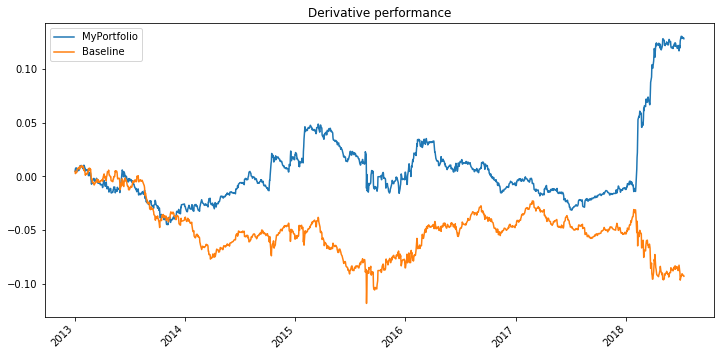

In [5]:
# MODEL: p.addModel(env.createModel("TrendFollowing", "TF7", args=("15:00", "16:00", True)))
#
# TODO - Notice how the simple trend following model works well when the market volatility changes in 2018. A 
# property of the market "stretching" so that the medium term (in this case bi-hourly) trends hit their sweet spot. 
# Earlier when volatility is lower and market is "compacted", the target trend term is longer (maybe 4-hourly). This 
# could be achieved with a MA with a dynamic window, or by dynamically modifying the time sample sizes. 

# TODO - The visualisation of the basline is misleading and does not show the cause of the performance (in this case the
# previous hours prices and the current hours prices, in a sequentional form). Perhaps we need to show period returns
# rather than daily returns (which is what getPeriodReturns provides)

trader.plot(p, baseline, includeComponents=False, includePrimary=True, log=True)

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2a4effa0f0>)

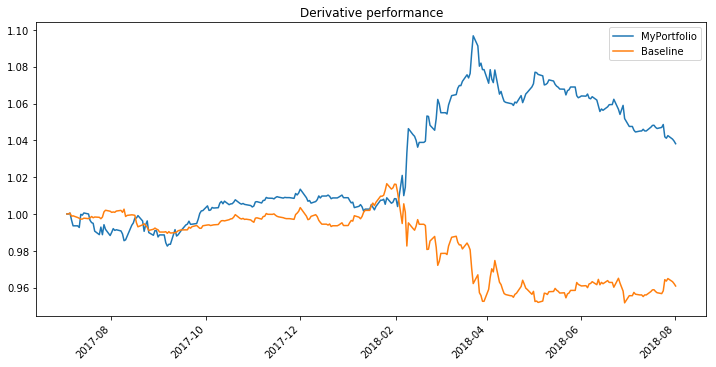

In [11]:
# TODO - EVEN MORE SUSPICIOUS PLOT - Why are Multiple Equally Weight MI signals generating the exact inverse of the baseline
# Sell signal until training period over (2000ish training set)?

import tradeframework.utils.trader as trader
#tInfo = env.getTradingInfo(context, dInfo, 10000)
trader.plot(p, baseline, includeComponents=False, includePrimary=True, log=False)

In [ ]:
import statsmodels.api as sm

# Fit the model
#x = x - x.mean()
mod_data = sm.tsa.MarkovAutoregression(x, k_regimes=2, order=1, trend='nc', switching_variance=True)
res_data = mod_data.fit()

res_data.summary()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, figsize=(10,7))

bInfo = bEnv.getTradingInfo(context, baseline, startCapital=1)
ax = axes[0]
ax.plot(bInfo.values[:,0])
ax.set(title='MR Strategy')

ax = axes[1]
ax.plot(tInfo.values[:,0]/10000)
ax.set(title='Market')

ax = axes[2]
ax.plot(x, 'ro')
ax.set(title='Returns')

ax = axes[3]
ax.plot(res_data.filtered_marginal_probabilities[0])
ax.set(title='Smoothed probability of a Momentum regime')

ax = axes[4]
ax.plot(res_data.filtered_marginal_probabilities[1])
ax.set(title='Smoothed probability of a Mean Reversion regime')

#ax = axes[4]
#ax.plot(res_data.filtered_marginal_probabilities[2])
#ax.set(title='Smoothed probability of a High Mean Reversion regime')

fig.tight_layout()